In [42]:
import numpy as np
import torch
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader

from ssapp.data.AntennaDatasetLoaders import PatchAntennaDataset, load_serialized_dataset,train_test_dataloader_split
from ssapp.Utils import train_test_data_split, FigureSaver
from ssapp import Utils
from ssapp.data.Metrics import relRMSE

figSaver = FigureSaver(default_format='png', dpi=600)

torch.manual_seed(42)

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2


# ## Load data
dataset = load_serialized_dataset('RFLCT')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def pca_score(model,x,y):
    pred = model.inverse_transform(model.transform(x))
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))

def pca_vs_dataset_size(test_ratios,model,dataset):
    training_size = []
    train_loss = []
    val_loss = []



    for idx,test_ratio in enumerate(test_ratios):
        train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=test_ratio)
        __, train_fields = next(iter(train_dataloader))
        train_fields = train_fields.reshape(len(train_fields),-1)


        training_size.append(len(train_fields))
        __, val_fields = next(iter(val_dataloader))

        val_fields = val_fields.reshape(len(val_fields),-1)
        
        model.fit(train_fields)

        train_loss.append(pca_score(model,train_fields,train_fields))
        val_loss.append(pca_score(model,val_fields,val_fields))
        print(f'Percent Done: {(idx+1)/len(test_ratios)*100}, Test Ratio: {test_ratio}, Training Size: {training_size[-1]}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}')

    return np.array(training_size),np.array(train_loss),np.array(val_loss)

In [3]:
#RFLCT
dataset = load_serialized_dataset('RFLCT')
pca = PCA(n_components=10)
RFLCT_training_size, RFLCT_train_loss, RFLCT_val_loss = pca_vs_dataset_size(np.logspace(-2.4,-0.1,10),pca,dataset)

# CircularHornDataset
dataset = load_serialized_dataset('CircularHornDataset1')
pca = PCA(n_components=10)
CHA1_training_size, CHA1_train_loss, CHA1_val_loss = pca_vs_dataset_size(np.logspace(-2.4,-0.1,10),pca,dataset)

# MLADataset
dataset = load_serialized_dataset('MLADataset1')
pca = PCA(n_components=10)
MLA1_training_size, MLA1_train_loss, MLA1_val_loss = pca_vs_dataset_size(np.logspace(-3,-0.1,10),pca,dataset)

# Patch Antenna Dataset
dataset = load_serialized_dataset('PatchAntennaDataset2')
pca = PCA(n_components=10)
PAD2_training_size, PAD2_train_loss, PAD2_val_loss = pca_vs_dataset_size(np.logspace(-2.4,-0.1,10),pca,dataset)

Percent Done: 10.0, Test Ratio: 0.003981071705534973, Training Size: 14, Train Loss: 0.0037106389623133692, Val Loss: 0.0190867702861377
Percent Done: 20.0, Test Ratio: 0.007170600970409613, Training Size: 25, Train Loss: 0.0063562199280129406, Val Loss: 0.01608595262823035
Percent Done: 30.0, Test Ratio: 0.01291549665014884, Training Size: 46, Train Loss: 0.008465914166609334, Val Loss: 0.012669859191965813
Percent Done: 40.0, Test Ratio: 0.02326305067153626, Training Size: 83, Train Loss: 0.00931333173115376, Val Loss: 0.011642771899835525
Percent Done: 50.0, Test Ratio: 0.04190079105786669, Training Size: 150, Train Loss: 0.010079350245029402, Val Loss: 0.011067658553281116
Percent Done: 60.0, Test Ratio: 0.07547059566968904, Training Size: 271, Train Loss: 0.010207148650567877, Val Loss: 0.010765932310113635
Percent Done: 70.0, Test Ratio: 0.13593563908785256, Training Size: 489, Train Loss: 0.01029710300282153, Val Loss: 0.01060959028344852
Percent Done: 80.0, Test Ratio: 0.244843

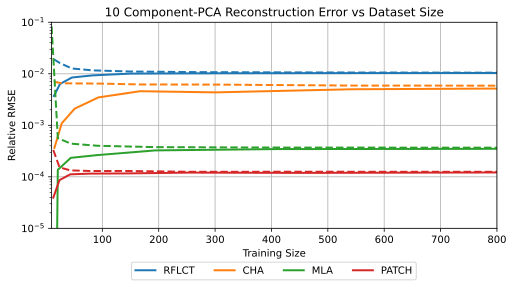

In [43]:
plt.figure(figsize=(8,3.8))
plt.plot(RFLCT_training_size,RFLCT_train_loss,label='RFLCT',c='C0',linewidth=2)
plt.plot(RFLCT_training_size,RFLCT_val_loss,c='C0',linestyle='--',linewidth=2)

# CHA
plt.plot(CHA1_training_size,CHA1_train_loss,label='CHA',c='C1',linewidth=2)
plt.plot(CHA1_training_size,CHA1_val_loss,c='C1',linestyle='--',linewidth=2)

# MLA
plt.plot(MLA1_training_size,MLA1_train_loss,label='MLA',c='C2',linewidth=2)
plt.plot(MLA1_training_size,MLA1_val_loss,c='C2',linestyle='--',linewidth=2)

# PAD
plt.plot(PAD2_training_size,PAD2_train_loss,label='PATCH',c='C3',linewidth=2)
plt.plot(PAD2_training_size,PAD2_val_loss,c='C3',linestyle='--',linewidth=2)

plt.legend(bbox_to_anchor=(0.83, -0.14),ncol=4) 
plt.grid()
#plt.xscale('log')
plt.yscale('log')
plt.xlim([10,0.8e3])
plt.ylim([1e-5,1e-1])
plt.xlabel('Training Size')
plt.ylabel('Relative RMSE')
plt.title('10 Component-PCA Reconstruction Error vs Dataset Size')
figSaver('10 Component-PCA Reconstruction Error vs Dataset Size')

In [5]:

for train_val_split in np.logspace(-2.4,-0.1,10):
    train_data,val_data = train_test_data_split(data,TRAIN_TEST_RATIO=train_val_split)

    print(len(train_data),len(val_data))

    train_dataloader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=len(val_data), shuffle=True)

    train_params, train_fields = next(iter(train_dataloader))
    val_params, val_fields = next(iter(val_dataloader))


    pca = PCA(n_components=10)
    pca = pca.fit(train_fields.reshape(len(train_fields), -1))
    train_latent = pca.transform(train_fields.reshape(len(train_fields), -1))
    val_latent = pca.transform(val_fields.reshape(len(val_fields), -1))

    train_loss = relRMSE(pca.inverse_transform(train_latent), train_fields.reshape(len(train_fields), -1))
    val_loss = relRMSE(pca.inverse_transform(val_latent), val_fields.reshape(len(val_fields), -1))

    print(f'Train loss: {train_loss}, Test Loss: {val_loss}')

NameError: name 'data' is not defined